Add Bullpen to Model

    - In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    - Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp7.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>2000) & (df.season<=2015) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [4]:
df.shape

(56765, 611)

In [5]:
hv_mean = df_train.home_victory.mean()

In [6]:
np.array(df.columns)

array(['date', 'dblheader_code', 'day_of_week', 'team_v', 'league_v',
       'game_no_v', 'team_h', 'league_h', 'game_no_h', 'runs_v', 'runs_h',
       'outs_total', 'day_night', 'completion_info', 'forfeit_info',
       'protest_info', 'ballpark_id', 'attendance', 'game_minutes',
       'linescore_v', 'linescore_h', 'AB_v', 'H_v', '2B_v', '3B_v',
       'HR_v', 'RBI_v', 'SH_v', 'SF_v', 'HBP_v', 'BB_v', 'IBB_v', 'SO_v',
       'SB_v', 'CS_v', 'GIDP_v', 'CI_v', 'LOB_v', 'P_num_v', 'ERind_v',
       'ERteam_v', 'WP_v', 'balk_v', 'PO_v', 'ASST_v', 'ERR_v', 'PB_v',
       'DP_v', 'TP_v', 'AB_h', 'H_h', '2B_h', '3B_h', 'HR_h', 'RBI_h',
       'SH_h', 'SF_h', 'HBP_h', 'BB_h', 'IBB_h', 'SO_h', 'SB_h', 'CS_h',
       'GIDP_h', 'CI_h', 'LOB_h', 'P_num_h', 'ERind_h', 'ERteam_h',
       'WP_h', 'balk_h', 'PO_h', 'ASST_h', 'ERR_h', 'PB_h', 'DP_h',
       'TP_h', 'ump_HB_id', 'ump_HB_name', 'ump_1B_id', 'ump_1B_name',
       'ump_2B_id', 'ump_2B_name', 'ump_3B_id', 'ump_3B_name',
       'ump_LF_id'

Let's add in some basic bullpen features

In [7]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [8]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

In [9]:
features1 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_14_h','Strt_WHIP_14_v',
            'Strt_TB_BB_perc_14_h', 'Strt_TB_BB_perc_14_v',
            'Strt_H_BB_perc_14_h', 'Strt_H_BB_perc_14_v',
            'Strt_SO_perc_14_h', 'Strt_SO_perc_14_v',
            ]

In [10]:
d1 = try_features(features1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[556]	valid_0's binary_logloss: 0.679749

Vegas probs: 0.6704071693200951 on test
model probs: 0.6801671450646944 on test

Difference: 0.009759975744599303 on test

Avg Shap Vals
Intercept               0.166244
Strt_SO_perc_14_v       0.108668
Strt_SO_perc_14_h       0.098668
OBP_162_v               0.066213
SLG_162_h               0.064566
OBP_162_h               0.057524
Strt_WHIP_14_h          0.049868
SLG_162_v               0.031527
Strt_TB_BB_perc_14_v    0.028814
Strt_TB_BB_perc_14_h    0.028316
Strt_H_BB_perc_14_h     0.026963
Strt_H_BB_perc_14_v     0.025835
Strt_WHIP_14_v          0.020359
dtype: float64


In [13]:
features2 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_14_h','Strt_WHIP_14_v',
            'Strt_TB_BB_perc_14_h', 'Strt_TB_BB_perc_14_v',
            'Strt_H_BB_perc_14_h', 'Strt_H_BB_perc_14_v',
            'Strt_SO_perc_14_h', 'Strt_SO_perc_14_v',
            'Bpen_WHIP_14_h','Bpen_WHIP_14_v',
            'Bpen_TB_BB_perc_14_h', 'Bpen_TB_BB_perc_14_v',
            'Bpen_H_BB_perc_14_h', 'Bpen_H_BB_perc_14_v',
            'Bpen_SO_perc_14_h', 'Bpen_SO_perc_14_v',
            ]

In [14]:
d2 = try_features(features2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[572]	valid_0's binary_logloss: 0.678879

Vegas probs: 0.6704071693200951 on test
model probs: 0.6786115485777887 on test

Difference: 0.008204379257693573 on test

Avg Shap Vals
Intercept               0.166227
Strt_SO_perc_14_h       0.096943
Strt_SO_perc_14_v       0.096930
OBP_162_v               0.055999
OBP_162_h               0.055587
SLG_162_h               0.049426
Strt_WHIP_14_h          0.045386
SLG_162_v               0.032407
Bpen_SO_perc_14_v       0.030821
Strt_TB_BB_perc_14_v    0.024978
Strt_TB_BB_perc_14_h    0.023315
Strt_H_BB_perc_14_v     0.023140
Strt_H_BB_perc_14_h     0.022262
Strt_WHIP_14_v          0.018150
Bpen_TB_BB_perc_14_h    0.011912
Bpen_H_BB_perc_14_h     0.010559
Bpen_H_BB_perc_14_v     0.010158
Bpen_WHIP_14_v          0.009850
Bpen_SO_perc_14_h       0.008256
Bpen_TB_BB_perc_14_v    0.007242
Bpen_WHIP_14_h          0.006741
dtype: float64


In [15]:
features3 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_14_h','Strt_WHIP_14_v',
            'Strt_TB_BB_perc_14_h', 'Strt_TB_BB_perc_14_v',
            'Strt_H_BB_perc_14_h', 'Strt_H_BB_perc_14_v',
            'Strt_SO_perc_3_h', 'Strt_SO_perc_3_v',
            'Bpen_WHIP_30_h','Bpen_WHIP_30_v',
            'Bpen_TB_BB_perc_30_h', 'Bpen_TB_BB_perc_30_v',
            'Bpen_H_BB_perc_30_h', 'Bpen_H_BB_perc_30_v',
            'Bpen_SO_perc_30_h', 'Bpen_SO_perc_30_v',
            'Bpen_WHIP_14_h','Bpen_WHIP_14_v',
            'Bpen_TB_BB_perc_14_h', 'Bpen_TB_BB_perc_14_v',
            'Bpen_H_BB_perc_14_h', 'Bpen_H_BB_perc_14_v',
            'Bpen_SO_perc_14_h', 'Bpen_SO_perc_14_v',
            'Bpen_WHIP_3_h','Bpen_WHIP_3_v',
            'Bpen_TB_BB_perc_3_h', 'Bpen_TB_BB_perc_3_v',
            'Bpen_H_BB_perc_3_h', 'Bpen_H_BB_perc_3_v',
            'Bpen_SO_perc_3_h', 'Bpen_SO_perc_3_v',
            ]

In [16]:
d3 = try_features(features3, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[636]	valid_0's binary_logloss: 0.679111

Vegas probs: 0.6704071693200951 on test
model probs: 0.6790282032529793 on test

Difference: 0.008621033932884159 on test

Avg Shap Vals
Intercept               0.166348
Strt_WHIP_14_h          0.056191
SLG_162_h               0.054300
OBP_162_h               0.052517
OBP_162_v               0.051130
Strt_SO_perc_3_v        0.047066
Strt_SO_perc_3_h        0.047021
SLG_162_v               0.037013
Bpen_TB_BB_perc_30_h    0.035661
Strt_TB_BB_perc_14_v    0.029921
Strt_H_BB_perc_14_v     0.027441
Strt_TB_BB_perc_14_h    0.027052
Strt_H_BB_perc_14_h     0.025564
Bpen_SO_perc_30_v       0.024650
Strt_WHIP_14_v          0.024584
Bpen_SO_perc_14_v       0.015655
Bpen_SO_perc_30_h       0.014423
Bpen_SO_perc_3_h        0.013135
Bpen_H_BB_perc_30_v     0.013000
Bpen_TB_BB_perc_30_v    0.011110
Bpen_SO_perc_3_v        0.010259
Bpen_SO_perc_14_h       0.006561

In [17]:
features4 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_30_h','Strt_WHIP_30_v',
            'Strt_TB_BB_perc_30_h', 'Strt_TB_BB_perc_30_v',
            'Strt_H_BB_perc_30_h', 'Strt_H_BB_perc_30_v',
            'Strt_SO_perc_30_h', 'Strt_SO_perc_30_v',
            'Strt_WHIP_14_h','Strt_WHIP_14_v',
            'Strt_TB_BB_perc_14_h', 'Strt_TB_BB_perc_14_v',
            'Strt_H_BB_perc_14_h', 'Strt_H_BB_perc_14_v',
            'Strt_SO_perc_14_h', 'Strt_SO_perc_14_v',
            'Strt_WHIP_3_h','Strt_WHIP_3_v',
            'Strt_TB_BB_perc_3_h', 'Strt_TB_BB_perc_3_v',
            'Strt_H_BB_perc_3_h', 'Strt_H_BB_perc_3_v',
            'Strt_SO_perc_3_h', 'Strt_SO_perc_3_v',
            'Bpen_WHIP_30_h','Bpen_WHIP_30_v',
            'Bpen_TB_BB_perc_30_h', 'Bpen_TB_BB_perc_30_v',
            'Bpen_H_BB_perc_30_h', 'Bpen_H_BB_perc_30_v',
            'Bpen_SO_perc_30_h', 'Bpen_SO_perc_30_v',
            'Bpen_WHIP_14_h','Bpen_WHIP_14_v',
            'Bpen_TB_BB_perc_14_h', 'Bpen_TB_BB_perc_14_v',
            'Bpen_H_BB_perc_14_h', 'Bpen_H_BB_perc_14_v',
            'Bpen_SO_perc_14_h', 'Bpen_SO_perc_14_v',
            'Bpen_WHIP_3_h','Bpen_WHIP_3_v',
            'Bpen_TB_BB_perc_3_h', 'Bpen_TB_BB_perc_3_v',
            'Bpen_H_BB_perc_3_h', 'Bpen_H_BB_perc_3_v',
            'Bpen_SO_perc_3_h', 'Bpen_SO_perc_3_v',
            ]

In [18]:
d4 = try_features(features4)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[556]	valid_0's binary_logloss: 0.67804

Vegas probs: 0.6704071693200951 on test
model probs: 0.6771991078552063 on test

Difference: 0.006791938535111175 on test

Avg Shap Vals
Intercept               0.166538
Strt_SO_perc_30_v       0.056956
OBP_162_h               0.049795
Strt_SO_perc_14_h       0.046686
SLG_162_h               0.045971
Strt_WHIP_30_h          0.043371
OBP_162_v               0.041823
Strt_H_BB_perc_30_v     0.033672
Strt_H_BB_perc_30_h     0.033473
Strt_SO_perc_14_v       0.032644
Bpen_TB_BB_perc_30_h    0.031406
SLG_162_v               0.031344
Strt_TB_BB_perc_30_h    0.030881
Strt_SO_perc_30_h       0.024557
Strt_WHIP_30_v          0.020195
Bpen_SO_perc_30_v       0.017838
Strt_TB_BB_perc_30_v    0.017333
Bpen_H_BB_perc_30_v     0.015000
Strt_SO_perc_3_v        0.012923
Bpen_SO_perc_14_v       0.012833
Strt_WHIP_3_v           0.011014
Bpen_SO_perc_30_h       0.009249


In [20]:
features5 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             'SB_162_h', 'SB_162_v',
             'CS_162_h', 'CS_162_v',
             
             
            'Strt_WHIP_14_h','Strt_WHIP_14_v',
            'Strt_TB_BB_perc_14_h', 'Strt_TB_BB_perc_14_v',
            'Strt_H_BB_perc_14_h', 'Strt_H_BB_perc_14_v',
            'Strt_SO_perc_3_h', 'Strt_SO_perc_3_v',
            'Bpen_WHIP_30_h','Bpen_WHIP_30_v',
            'Bpen_TB_BB_perc_30_h', 'Bpen_TB_BB_perc_30_v',
            'Bpen_H_BB_perc_30_h', 'Bpen_H_BB_perc_30_v',
            'Bpen_SO_perc_30_h', 'Bpen_SO_perc_30_v',
            'Bpen_WHIP_14_h','Bpen_WHIP_14_v',
            'Bpen_TB_BB_perc_14_h', 'Bpen_TB_BB_perc_14_v',
            'Bpen_H_BB_perc_14_h', 'Bpen_H_BB_perc_14_v',
            'Bpen_SO_perc_14_h', 'Bpen_SO_perc_14_v',
            'Bpen_WHIP_3_h','Bpen_WHIP_3_v',
            'Bpen_TB_BB_perc_3_h', 'Bpen_TB_BB_perc_3_v',
            'Bpen_H_BB_perc_3_h', 'Bpen_H_BB_perc_3_v',
            'Bpen_SO_perc_3_h', 'Bpen_SO_perc_3_v',
            ]

In [21]:
d5 = try_features(features5)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[703]	valid_0's binary_logloss: 0.679401

Vegas probs: 0.6704071693200951 on test
model probs: 0.6790591746500585 on test

Difference: 0.008652005329963353 on test

Avg Shap Vals
Intercept               0.166414
Strt_WHIP_14_h          0.052262
OBP_162_h               0.051588
SLG_162_h               0.048741
Strt_SO_perc_3_v        0.047909
Strt_SO_perc_3_h        0.044468
OBP_162_v               0.044354
SLG_162_v               0.036260
Bpen_TB_BB_perc_30_h    0.033357
Strt_TB_BB_perc_14_v    0.030692
Strt_TB_BB_perc_14_h    0.027260
Strt_H_BB_perc_14_h     0.026073
Strt_WHIP_14_v          0.025925
Strt_H_BB_perc_14_v     0.024433
Bpen_SO_perc_30_v       0.023898
ERR_162_h               0.015713
Bpen_H_BB_perc_30_v     0.015264
Bpen_SO_perc_14_v       0.015253
ERR_162_v               0.013261
SB_162_v                0.012941
Bpen_SO_perc_3_h        0.012089
Bpen_SO_perc_30_h       0.011569

In [22]:
rd = mli.get_range_dict(df_train)
plot_pts = df_test.loc[:,features5].sample(1, random_state=42)

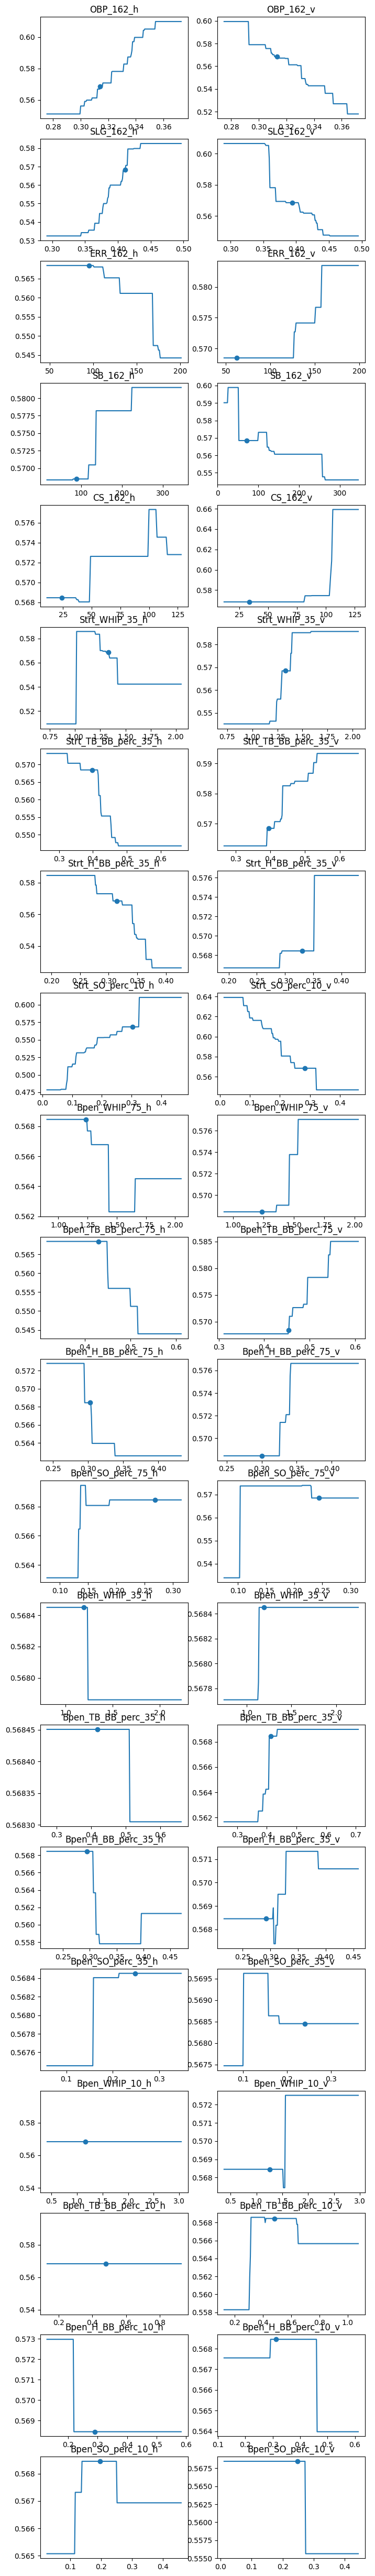

In [22]:
mli.ice_plot(d5['model'], plot_pts, features5, rd, plots_per_row=2)

In [23]:
df['SBadj_162_h'] = df['SB_162_h'] - 3*df['CS_162_h']
df['SBadj_162_v'] = df['SB_162_v'] - 3*df['CS_162_v']

In [24]:
df_train = df[(df.season>2000) & (df.season<=2015) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [25]:
len(df.OBP_162_h)

56765

In [26]:
features6  = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             # 'SB_162_h', 'SB_162_v',
             # 'CS_162_h', 'CS_162_v',
             'SBadj_162_h','SBadj_162_v',
             
            'Strt_WHIP_14_h','Strt_WHIP_14_v',
            'Strt_TB_BB_perc_14_h', 'Strt_TB_BB_perc_14_v',
            'Strt_H_BB_perc_14_h', 'Strt_H_BB_perc_14_v',
            'Strt_SO_perc_3_h', 'Strt_SO_perc_3_v',
            'Bpen_WHIP_30_h','Bpen_WHIP_30_v',
            'Bpen_TB_BB_perc_30_h', 'Bpen_TB_BB_perc_30_v',
            'Bpen_H_BB_perc_30_h', 'Bpen_H_BB_perc_30_v',
            'Bpen_SO_perc_30_h', 'Bpen_SO_perc_30_v',
            'Bpen_WHIP_14_h','Bpen_WHIP_14_v',
            'Bpen_TB_BB_perc_14_h', 'Bpen_TB_BB_perc_14_v',
            'Bpen_H_BB_perc_14_h', 'Bpen_H_BB_perc_14_v',
            'Bpen_SO_perc_14_h', 'Bpen_SO_perc_14_v',
            'Bpen_WHIP_3_h','Bpen_WHIP_3_v',
            'Bpen_TB_BB_perc_3_h', 'Bpen_TB_BB_perc_3_v',
            'Bpen_H_BB_perc_3_h', 'Bpen_H_BB_perc_3_v',
            'Bpen_SO_perc_3_h', 'Bpen_SO_perc_3_v',
            ]


In [27]:
d6 = try_features(features6)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[765]	valid_0's binary_logloss: 0.679072

Vegas probs: 0.6704071693200951 on test
model probs: 0.6791360024632956 on test

Difference: 0.008728833143200498 on test

Avg Shap Vals
Intercept               0.166571
OBP_162_h               0.052462
Strt_WHIP_14_h          0.051134
SLG_162_h               0.050007
Strt_SO_perc_3_v        0.049609
OBP_162_v               0.049234
Strt_SO_perc_3_h        0.045038
SLG_162_v               0.035349
Bpen_TB_BB_perc_30_h    0.032140
Strt_TB_BB_perc_14_v    0.032067
Strt_H_BB_perc_14_h     0.028083
Strt_TB_BB_perc_14_h    0.027692
Strt_WHIP_14_v          0.026026
Strt_H_BB_perc_14_v     0.023968
Bpen_SO_perc_30_v       0.023805
SBadj_162_v             0.020768
SBadj_162_h             0.018784
Bpen_SO_perc_14_v       0.016084
ERR_162_h               0.015769
Bpen_H_BB_perc_30_v     0.015550
Bpen_SO_perc_3_h        0.014246
ERR_162_v               0.012553

Let's analyze model 3 (our best model so far)

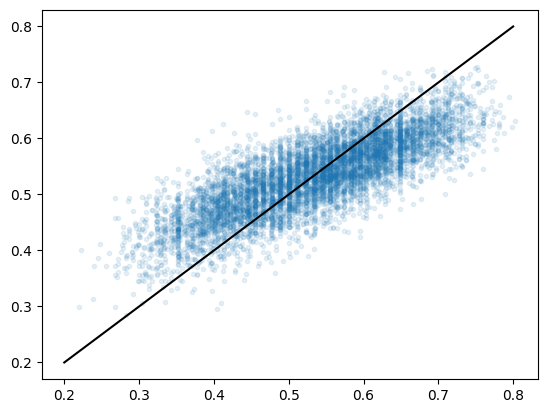

In [28]:
plt.scatter(df_test.implied_prob_h_mid, d3['preds_test'], marker='.', alpha=.1)
plt.plot([.2,.8],[.2,.8], color='k')

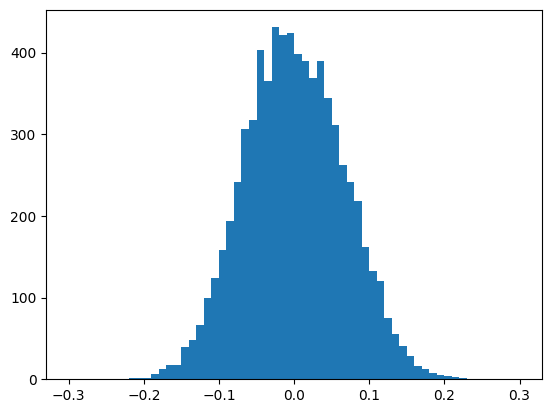

In [29]:
test_disc = d3['preds_test'] - df_test.implied_prob_h_mid
plt.hist(test_disc, bins=np.linspace(-.3,.3,61));

In [30]:
## let's compare performance on the cases with a large discrepancy
mask = (np.abs(test_disc))>.1
log_loss(y_test[mask], d3['preds_test'][mask]), log_loss(y_test[mask], df_test.implied_prob_h_mid[mask])

(0.6773505135363447, 0.6460670496102819)

In [31]:
log_loss(y_test[~mask], d3['preds_test'][~mask]), log_loss(y_test[~mask], df_test.implied_prob_h_mid[~mask])

(0.6792755363093299, 0.6739955063886707)

Conclusions
    - Still about 40 bps away from Vegas probabilities (down from ~70)
    - When our model and Vegas "disagree", Vegas is generally right!

    - We are running out of "big wins"
    - Features based on actual starting lineup
    - Fielding
    - Lefty vs Righty analysis

Next Steps

    - Get individual batter data
    - Make features based on the actual lineup
    - Analyze runs scored (over/under)
    - Perhaps the model for runs scored will help with the moneyline model